# Simple simulation
modified by Daniel Haenelt (2025-06-23)

In [1]:
import sys
sys.path.insert(0, '/Users/dh014/projects/DeepCor/DeepCor_pkg')

import math
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from numpy import random
from torch.utils.data import random_split
from sklearn.decomposition import PCA
from sklearn import linear_model
from DeepCor.utils import Scaler, TrainDataset, r_squared_list
from DeepCor.DeepCor import DeepCorTrainer

# --- global plot configuration ---
mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14


# parameters
combine_nonlinear = True  # linear or nonlinear combination of signal and noise
n_time = 156  # time series length
num_obs = 10000 # number of observations

random.seed(42)

In [2]:
def create_signal():
    """Generate noise and signal separately as a sine function with noise."""
    a_n = random.uniform(5, 10)
    b_n = random.uniform(0.1, 1)
    c_n = random.uniform(200, 300)
    y_n = np.array([a_n*np.sin(i*b_n) + c_n+0.01*random.randint(-100,100) for i in range(n_time)])
    a_s = random.uniform(5, 10)
    b_s = random.uniform(1, 3)
    c_s = random.uniform(200, 300)
    y_s = np.array([a_s*np.sin(i*b_s) + c_s+0.01*random.randint(-100,100) for i in range(n_time)])
    return [y_n, y_s]

In [3]:
ground_truth_list = np.zeros([num_obs, n_time]) # initialization of ground truths
observation_list = np.zeros([num_obs, n_time]) # initialization of observations
noise_list = np.zeros([num_obs, n_time]) # initialization of noises
# generation of noises and ground truths
for i in range(num_obs):
    [noise_list[i],ground_truth_list[i]] = create_signal()

In [4]:
# subtracting means from noises and ground truths across each sequence
noise_list = noise_list - np.repeat(np.reshape(np.mean(noise_list,axis=1), (noise_list.shape[0],1)), noise_list.shape[1], axis=1)
ground_truth_list = ground_truth_list - np.repeat(np.reshape(np.mean(ground_truth_list,axis=1), (ground_truth_list.shape[0],1)), ground_truth_list.shape[1], axis=1)

In [5]:
# normalize the grounth truth
gt_scale = Scaler(ground_truth_list)
gt_list = gt_scale.transform(ground_truth_list)

In [6]:
if combine_nonlinear:
    # non-linear combination of noise and ground truth, leading to the observations, and 
    # standard deviation is arbitrary
    std = 0.5
    cube_root = np.cbrt(noise_list)
    lamb = (std**2/(cube_root.std())**2)**(3/2)
    noise_c = np.cbrt(lamb * noise_list)
    print(noise_c.mean())
    print(noise_c.std())
    observation_list = gt_list + noise_c
else:
    # linear combination of noise and ground truth, leading to the observations, and 
    # standard deviation is arbitrary
    std = 2
    lamb = math.sqrt(std**2/noise_list.std()**2)
    noise_c = lamb * noise_list
    print(noise_c.mean())
    print(noise_c.std())
    observation_list = gt_list + noise_c

0.004245169193501532
0.49999999999999994


In [7]:
# normalization of observations and noises
obs_scale = Scaler(observation_list)
obs_list = obs_scale.transform(observation_list)
noi_scale = Scaler(noise_list)
noi_list = noi_scale.transform(noise_list)

print(obs_list.mean())
print(obs_list.std())
print(noi_list.mean())
print(noi_list.std())

1.0120109878313927e-19
1.0
1.8261745392231742e-19
1.0


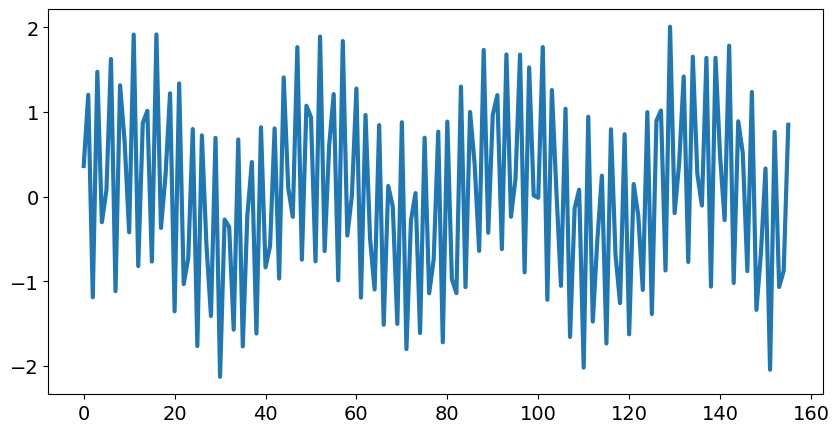

In [8]:
x = [i for i in range(n_time)]
fig, ax = plt.subplots(figsize = (10,5))
_ = ax.plot(x, observation_list[40])

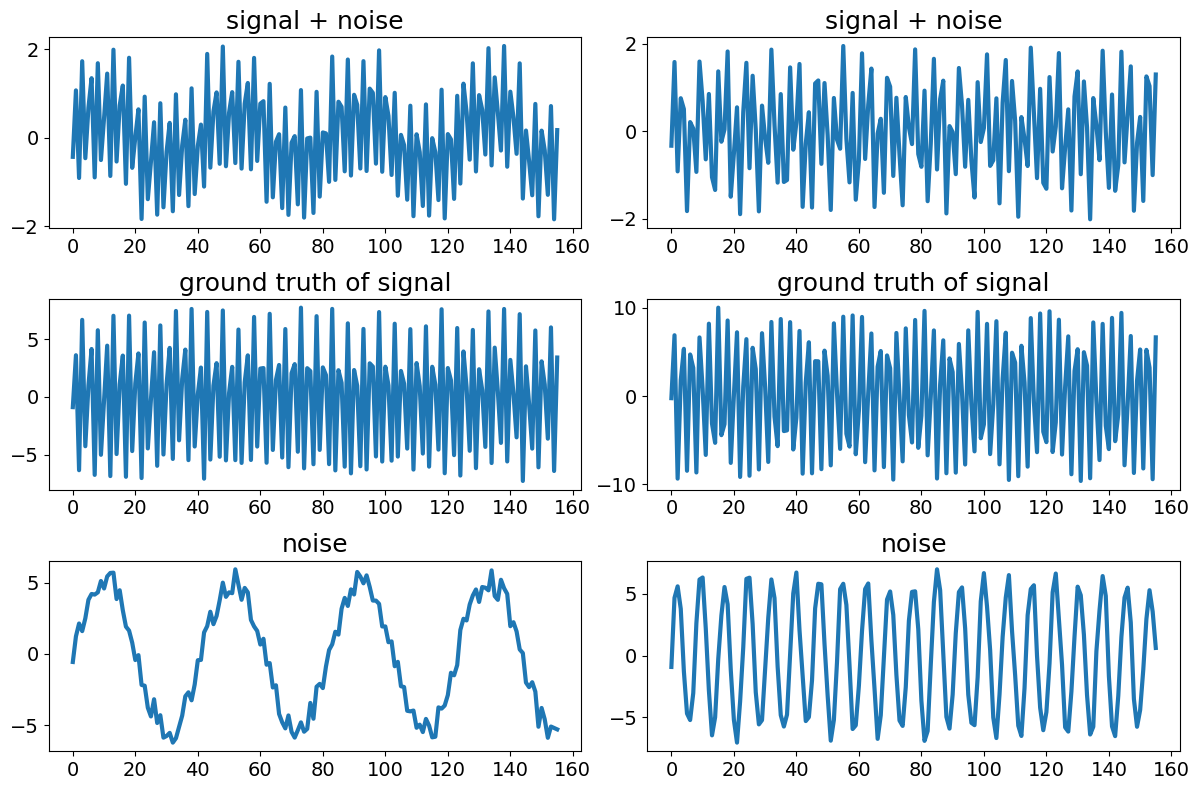

In [9]:
# sample indices
idx1, idx2 = 900, 24

x = list(range(n_time))
data_pairs = [
    (observation_list[idx1], "signal + noise"),
    (observation_list[idx2], "signal + noise"),
    (ground_truth_list[idx1], "ground truth of signal"),
    (ground_truth_list[idx2], "ground truth of signal"),
    (noise_list[idx1], "noise"),
    (noise_list[idx2], "noise")
]

fig, axs = plt.subplots(3, 2, figsize=(12, 8))
for i, (data, title) in enumerate(data_pairs):
    row, col = divmod(i, 2)
    ax = axs[row, col]
    ax.plot(x, data)
    ax.set_title(title)
plt.tight_layout()

# DataLoader

In [10]:
# initiate dataset in pytorch
inputs_all = TrainDataset(obs_list,gt_list,noi_list)
generator = torch.Generator().manual_seed(42)
train_inputs, val_inputs, test_inputs = random_split(inputs_all, [0.7, 0.15, 0.15], generator=generator)

In [11]:
# dataloader
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=64, shuffle=True, num_workers=1)
val_in = torch.utils.data.DataLoader(val_inputs, batch_size=len(val_inputs), shuffle=False, num_workers=1)
test_in = torch.utils.data.DataLoader(test_inputs, batch_size=len(test_inputs), shuffle=False, num_workers=1)

# Training the Model

In [12]:
trainer = DeepCorTrainer(16, n_time, hidden_dims=[64, 128, 256, 256], lr=0.001, weight_decay=0)
model = trainer.train(train_in, val_in)

Current device: cpu
Epoch 1/200
----------
Train Loss: 0.5985  Recon: 0.5974  KLD: 114.2992
Val Loss:   0.7202  Recon: 0.7168  KLD: 343.4236

Epoch 2/200
----------
Train Loss: 0.2919  Recon: 0.2902  KLD: 170.1259
Val Loss:   0.4907  Recon: 0.4869  KLD: 380.5709

Epoch 3/200
----------
Train Loss: 0.1389  Recon: 0.1370  KLD: 196.2220
Val Loss:   0.3154  Recon: 0.3107  KLD: 465.0940

Epoch 4/200
----------
Train Loss: 0.0764  Recon: 0.0742  KLD: 220.1660
Val Loss:   0.2468  Recon: 0.2422  KLD: 460.8085

Epoch 5/200
----------
Train Loss: 0.0577  Recon: 0.0555  KLD: 220.3448
Val Loss:   0.2214  Recon: 0.2167  KLD: 476.4993

Epoch 6/200
----------
Train Loss: 0.0525  Recon: 0.0503  KLD: 221.2205
Val Loss:   0.2321  Recon: 0.2274  KLD: 470.2821

Epoch 7/200
----------
Train Loss: 0.0467  Recon: 0.0445  KLD: 221.3486
Val Loss:   0.2105  Recon: 0.2059  KLD: 461.5596

Epoch 8/200
----------
Train Loss: 0.0437  Recon: 0.0416  KLD: 219.3670
Val Loss:   0.2181  Recon: 0.2135  KLD: 460.7089

Epoc

In [13]:
# get the r_squred scores for testing data
test_r_squared_list = trainer.test(test_in)
# calculate mean and percentiles of R-squred
test_mean = test_r_squared_list.mean()
test_percentile= (np.percentile(test_r_squared_list, 5), np.percentile(test_r_squared_list, 95))
print("DeepCor testing R squared mean is "+str(test_mean))
print("DeepCor testing R squared percentile is "+str(test_percentile))

DeepCor testing R squared mean is 0.927045760794538
DeepCor testing R squared percentile is (np.float64(0.8259854525856063), np.float64(0.9671826504574328))


# Show loss

In [14]:
train_loss = trainer.train_loss_L
train_recon_loss = trainer.train_recons_L
train_kld_loss = trainer.train_KLD_L

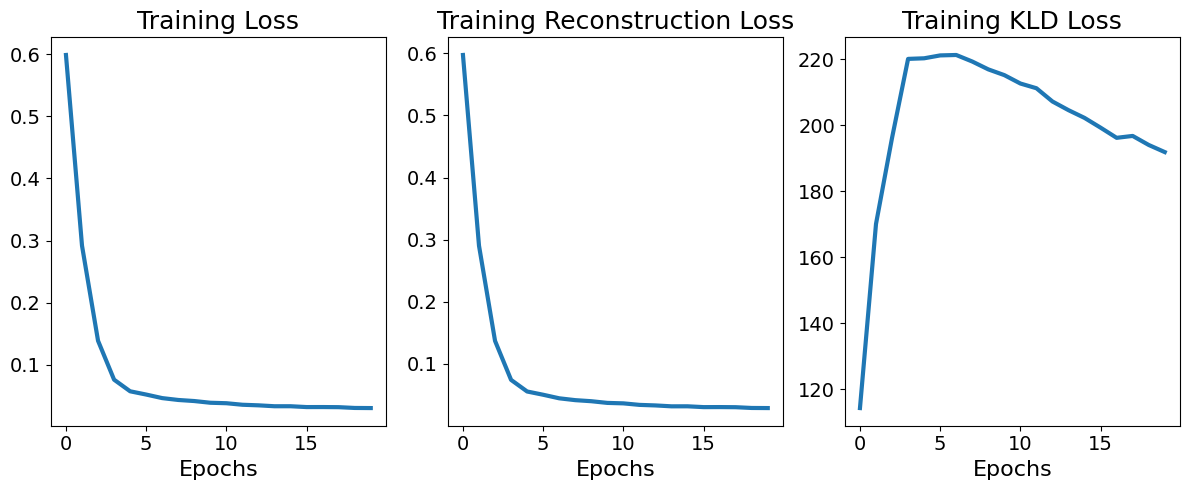

In [15]:
num_list = list(range(len(train_loss)))

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

axs[0].plot(num_list, train_loss)
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epochs')

axs[1].plot(num_list, train_recon_loss)
axs[1].set_title('Training Reconstruction Loss')
axs[1].set_xlabel('Epochs')

axs[2].plot(num_list, train_kld_loss)
axs[2].set_title('Training KLD Loss')
axs[2].set_xlabel('Epochs')

plt.tight_layout()

In [16]:
val_loss = trainer.val_loss_L
val_recon_loss = trainer.val_recons_L
val_kld_loss = trainer.val_KLD_L

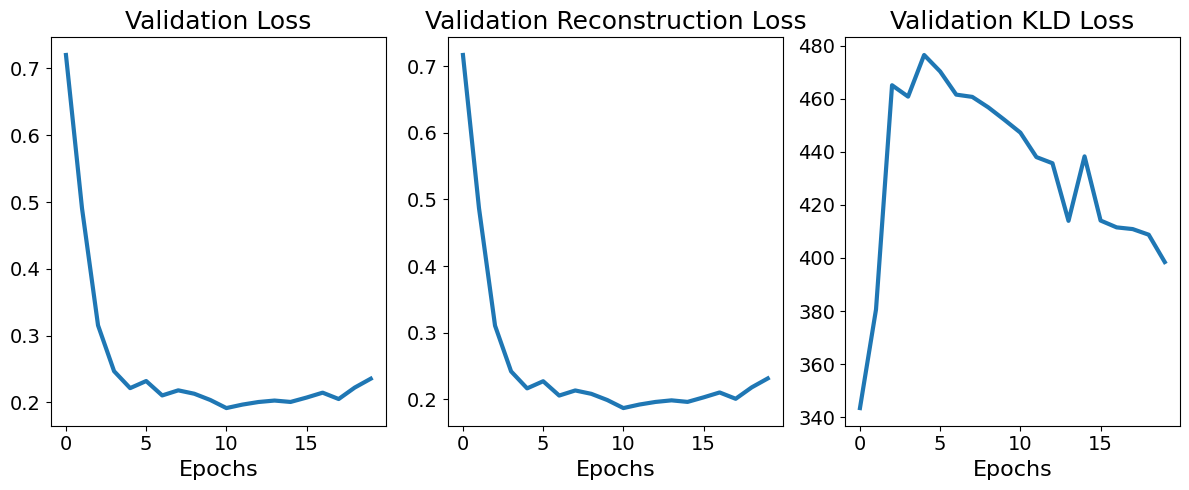

In [17]:
num_list = list(range(len(train_loss)))

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

axs[0].plot(num_list, val_loss)
axs[0].set_title('Validation Loss')
axs[0].set_xlabel('Epochs')

axs[1].plot(num_list, val_recon_loss)
axs[1].set_title('Validation Reconstruction Loss')
axs[1].set_xlabel('Epochs')

axs[2].plot(num_list, val_kld_loss)
axs[2].set_title('Validation KLD Loss')
axs[2].set_xlabel('Epochs')

plt.tight_layout()

In [18]:
# load test data
test_gm, test_gt, test_cf = next(iter(test_in))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_ = test_gm.unsqueeze(1).float().to(device)
output_denoised, _, _, _ = model.forward_fg(input_)
output_noise, _, _, _ = model.forward_bg(input_)

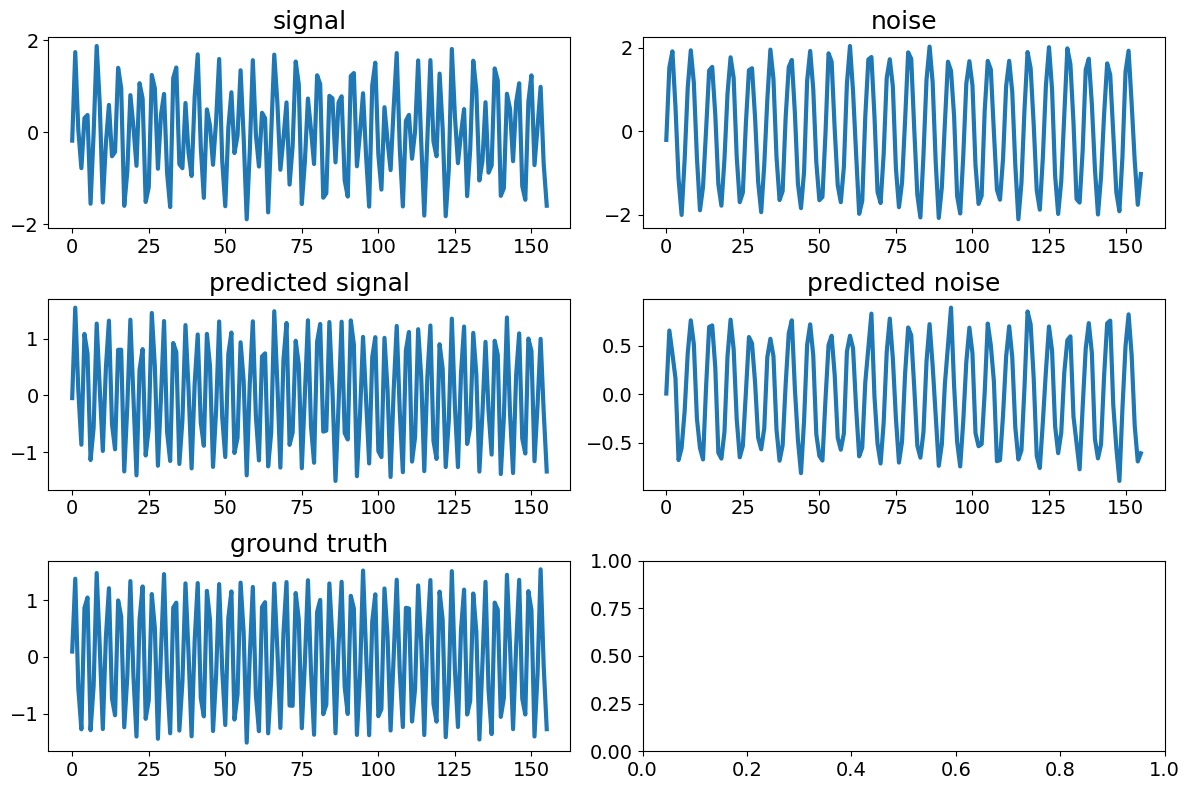

In [19]:
# sample index
idx = 20

x = list(range(n_time))
data_pairs = [
    (test_gm.detach().numpy()[idx, :], "signal"),
    (test_cf.detach().numpy()[idx, :], "noise"),
    (output_denoised.detach().numpy()[idx, 0, :], "predicted signal"),
    (output_noise.detach().numpy()[idx, 0, :], "predicted noise"),
    (test_gt.detach().numpy()[idx, :], "ground truth"),
]

fig, axs = plt.subplots(3, 2, figsize=(12, 8))
for i, (data, title) in enumerate(data_pairs):
    row, col = divmod(i, 2)
    ax = axs[row, col]
    ax.plot(x, data)
    ax.set_title(title)
plt.tight_layout()

# CompCorr


In [20]:
dataloader_iter_in = iter(train_in)
train_gm, train_gt, train_cf = next(dataloader_iter_in)
for i in range(1, len(train_in)):
    train_gm_new, train_gt_new, train_cf_new = next(dataloader_iter_in)
    train_gm = np.concatenate((train_gm, train_gm_new), axis=0)
    train_cf = np.concatenate((train_cf, train_cf_new), axis=0)
print(train_gm.shape)
print(train_cf.shape)

(7000, 156)
(7000, 156)


In [21]:
test_gm, test_gt,test_cf = next(iter(test_in))
test_gm = test_gm.numpy()
test_gt = test_gt.numpy()
test_cf = test_cf.numpy()

In [22]:
# PCA likes the time dimension as first. Let's transpose our data.
train_gm_t = np.transpose(train_gm)
train_cf_t = np.transpose(train_cf)
test_gm_t = np.transpose(test_gm)
test_cf_t = np.transpose(test_cf)
test_gt_t = np.transpose(test_gt)
# Fit PCA and extract PC timecourses
pca = PCA(n_components = 5)
confounds_pc = pca.fit_transform(train_cf_t)
confounds_pc.shape

(156, 5)

In [23]:
# linear regression on each voxel: PCs -> voxel pattern
linear = linear_model.LinearRegression()
linear.fit(confounds_pc, test_gm_t)

# predict the activity of each voxel for this run
predict = linear.predict(confounds_pc)
func_denoised = test_gm_t - predict # t x v
func_denoised = np.transpose(func_denoised) # v x t
func_denoised.shape

(1500, 156)

In [24]:
compcor_r_squared_list = r_squared_list(test_gt, func_denoised)
compcor_test_mean = compcor_r_squared_list.mean()
compcor_test_percentile= (np.percentile(compcor_r_squared_list, 5), np.percentile(compcor_r_squared_list, 95))
print(compcor_test_mean)
print(compcor_test_percentile)

0.8185766729049866
(np.float64(0.7739499269094525), np.float64(0.9034963143487195))


In [25]:
np.shape(predict)

(156, 1500)

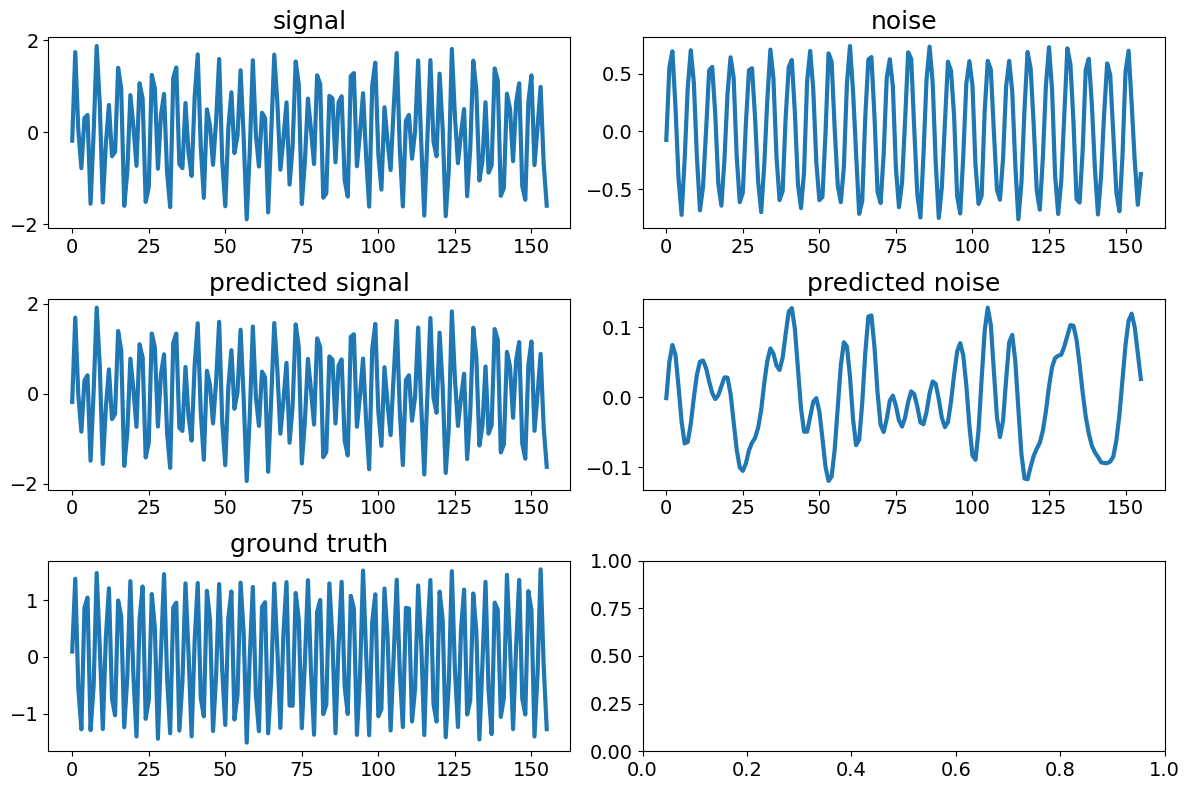

In [26]:
# sample index
idx = 20

x = list(range(n_time))
data_pairs = [
    (test_gm[idx, :], "signal"),
    (test_cf[idx, :], "noise"),
    (func_denoised[idx, :], "predicted signal"),
    (np.transpose(predict)[idx, :], "predicted noise"),
    (test_gt[idx, :], "ground truth"),
]

fig, axs = plt.subplots(3, 2, figsize=(12, 8))
for i, (data, title) in enumerate(data_pairs):
    row, col = divmod(i, 2)
    ax = axs[row, col]
    ax.plot(x, data)
    ax.set_title(title)
plt.tight_layout()

# Wilcoxon Test z+s std=1

In [27]:
scipy.stats.wilcoxon(x=test_r_squared_list, y=compcor_r_squared_list,alternative='greater')

WilcoxonResult(statistic=np.float64(1109328.0), pvalue=np.float64(5.846150745165921e-233))